# DFL benchmark - training
This is a simple benchmark script for DFL.  
It classifies each frame image in the video into 4 classes（'background','challenge','play','throwin'） 
It does not use temporal information, so it may not be competitive on its own for this competition, but it could be used as a feature extractor for more advanced models.

In [42]:
!nvidia-smi

Failed to initialize NVML: Unknown Error


In [43]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from IPython.display import Video
import cv2

# setting

In [44]:
DEBUG = True

In [45]:
class CFG:
    train_csv = "/workdir/work/input/train.csv"
    video_dir = "/workdir/work/input/train"

    result_dir = f"/workdir/work/output/train_images_flowvec/"
    output_train_csv = "/workdir/work/output/train_images_flowvec.csv"

    # optical flow settings
    # params for ShiTomasi corner detection
    feature_params = dict( maxCorners = 100,
                        qualityLevel = 0.3,
                        minDistance = 7,
                        blockSize = 7 )

    # Parameters for lucas kanade optical flow
    lk_params = dict( winSize  = (15,15),
                    maxLevel = 2,
                    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
    
    CAL_FLOW_TIME = 0.3
    skip_time_interval = 0.3
    crop_range = 800
    area_thr = 0.2
    IMG_SIZE = 456
    dis_thr = 5.0

# Scoring functions

In [46]:
# copy from https://www.kaggle.com/code/ryanholbrook/competition-metric-dfl-event-detection-ap

import numpy as np
import pandas as pd
from pandas.testing import assert_index_equal
from typing import Dict, Tuple

tolerances = {
    "challenge": [0.3, 0.4, 0.5, 0.6, 0.7],
    "play": [0.15, 0.20, 0.25, 0.30, 0.35],
    "throwin": [0.15, 0.20, 0.25, 0.30, 0.35],
}

def filter_detections(
        detections: pd.DataFrame, intervals: pd.DataFrame
) -> pd.DataFrame:
    """Drop detections not inside a scoring interval."""
    detection_time = detections.loc[:, 'time'].sort_values().to_numpy()
    intervals = intervals.to_numpy()
    is_scored = np.full_like(detection_time, False, dtype=bool)

    i, j = 0, 0
    while i < len(detection_time) and j < len(intervals):
        time = detection_time[i]
        int_ = intervals[j]

        # If the detection is prior in time to the interval, go to the next detection.
        if time < int_.left:
            i += 1
        # If the detection is inside the interval, keep it and go to the next detection.        
        elif time in int_:
            is_scored[i] = True
            i += 1
        # If the detection is later in time, go to the next interval.
        else:
            j += 1

    return detections.loc[is_scored].reset_index(drop=True)


def match_detections(
        tolerance: float, ground_truths: pd.DataFrame, detections: pd.DataFrame
) -> pd.DataFrame:
    """Match detections to ground truth events. Arguments are taken from a common event x tolerance x video evaluation group."""
    detections_sorted = detections.sort_values('score', ascending=False).dropna()

    is_matched = np.full_like(detections_sorted['event'], False, dtype=bool)
    gts_matched = set()
    for i, det in enumerate(detections_sorted.itertuples(index=False)):
        best_error = tolerance
        best_gt = None

        for gt in ground_truths.itertuples(index=False):
            error = abs(det.time - gt.time)
            if error < best_error and not gt in gts_matched:
                best_gt = gt
                best_error = error
            
        if best_gt is not None:
            is_matched[i] = True
            gts_matched.add(best_gt)

    detections_sorted['matched'] = is_matched

    return detections_sorted


def precision_recall_curve(
        matches: np.ndarray, scores: np.ndarray, p: int
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    if len(matches) == 0:
        return [1], [0], []

    # Sort matches by decreasing confidence
    idxs = np.argsort(scores, kind='stable')[::-1]
    scores = scores[idxs]
    matches = matches[idxs]
    
    distinct_value_indices = np.where(np.diff(scores))[0]
    threshold_idxs = np.r_[distinct_value_indices, matches.size - 1]
    thresholds = scores[threshold_idxs]
    
    # Matches become TPs and non-matches FPs as confidence threshold decreases
    tps = np.cumsum(matches)[threshold_idxs]
    fps = np.cumsum(~matches)[threshold_idxs]
    
    precision = tps / (tps + fps)
    precision[np.isnan(precision)] = 0
    recall = tps / p  # total number of ground truths might be different than total number of matches
    
    # Stop when full recall attained and reverse the outputs so recall is non-increasing.
    last_ind = tps.searchsorted(tps[-1])
    sl = slice(last_ind, None, -1)

    # Final precision is 1 and final recall is 0
    return np.r_[precision[sl], 1], np.r_[recall[sl], 0], thresholds[sl]


def average_precision_score(matches: np.ndarray, scores: np.ndarray, p: int) -> float:
    precision, recall, _ = precision_recall_curve(matches, scores, p)
    # Compute step integral
    return -np.sum(np.diff(recall) * np.array(precision)[:-1])


def event_detection_ap(
        solution: pd.DataFrame,
        submission: pd.DataFrame,
        tolerances: Dict[str, float],
) -> float:

    assert_index_equal(solution.columns, pd.Index(['video_id', 'time', 'event']))
    assert_index_equal(submission.columns, pd.Index(['video_id', 'time', 'event', 'score']))

    # Ensure solution and submission are sorted properly
    solution = solution.sort_values(['video_id', 'time'])
    submission = submission.sort_values(['video_id', 'time'])
    
    # Extract scoring intervals.
    intervals = (
        solution
        .query("event in ['start', 'end']")
        .assign(interval=lambda x: x.groupby(['video_id', 'event']).cumcount())
        .pivot(index='interval', columns=['video_id', 'event'], values='time')
        .stack('video_id')
        .swaplevel()
        .sort_index()
        .loc[:, ['start', 'end']]
        .apply(lambda x: pd.Interval(*x, closed='both'), axis=1)
    )

    # Extract ground-truth events.
    ground_truths = (
        solution
        .query("event not in ['start', 'end']")
        .reset_index(drop=True)
    )

    # Map each event class to its prevalence (needed for recall calculation)
    class_counts = ground_truths.value_counts('event').to_dict()

    # Create table for detections with a column indicating a match to a ground-truth event
    detections = submission.assign(matched = False)

    # Remove detections outside of scoring intervals
    detections_filtered = []
    for (det_group, dets), (int_group, ints) in zip(
        detections.groupby('video_id'), intervals.groupby('video_id')
    ):
        assert det_group == int_group
        detections_filtered.append(filter_detections(dets, ints))
    detections_filtered = pd.concat(detections_filtered, ignore_index=True)

    # Create table of event-class x tolerance x video_id values
    aggregation_keys = pd.DataFrame(
        [(ev, tol, vid)
         for ev in tolerances.keys()
         for tol in tolerances[ev]
         for vid in ground_truths['video_id'].unique()],
        columns=['event', 'tolerance', 'video_id'],
    )

    # Create match evaluation groups: event-class x tolerance x video_id
    detections_grouped = (
        aggregation_keys
        .merge(detections_filtered, on=['event', 'video_id'], how='left')
        .groupby(['event', 'tolerance', 'video_id'])
    )
    ground_truths_grouped = (
        aggregation_keys
        .merge(ground_truths, on=['event', 'video_id'], how='left')
        .groupby(['event', 'tolerance', 'video_id'])
    )
    
    # Match detections to ground truth events by evaluation group
    detections_matched = []
    for key in aggregation_keys.itertuples(index=False):
        dets = detections_grouped.get_group(key)
        gts = ground_truths_grouped.get_group(key)
        detections_matched.append(
            match_detections(dets['tolerance'].iloc[0], gts, dets)
        )
    detections_matched = pd.concat(detections_matched)
    
    # Compute AP per event x tolerance group
    event_classes = ground_truths['event'].unique()
    ap_table = (
        detections_matched
        .query("event in @event_classes")
        .groupby(['event', 'tolerance']).apply(
        lambda group: average_precision_score(
        group['matched'].to_numpy(),
                group['score'].to_numpy(),
                class_counts[group['event'].iat[0]],
            )
        )
    )

    # Average over tolerances, then over event classes
    mean_ap = ap_table.groupby('event').mean().mean()

    return mean_ap

# optical flow functions

In [47]:
def get_maxflow_area(x, y, width, height, crop_range=CFG.crop_range):
    crop_x_min = int(x) - (crop_range/2)
    crop_x_max = int(x) + (crop_range/2)
    crop_x_min = max(0, crop_x_min)
    crop_x_max = min(width, crop_x_max)

    crop_y_min = int(y) - (crop_range/2)
    crop_y_max = int(y) + (crop_range/2)
    crop_y_min = max(0, crop_y_min)
    crop_y_max = min(height, crop_y_max)

    return int(crop_x_min), int(crop_x_max), int(crop_y_min), int(crop_y_max)

In [48]:
def get_green_area(img):
    # HSV
    img_HSV = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    # creat green mask (H value for green is from 100/360*179 until 180/360*179) in OpenCV
    lower_green = np.array([100 / 360 * 179, 0, 0])
    upper_green = np.array([180 / 360 * 179, 255, 255])
    green_mask = cv2.inRange(img_HSV, lower_green, upper_green)

    # crop green area
    img_green_masked = cv2.bitwise_and(img, img, mask=green_mask)
    img_green_masked = cv2.cvtColor(img_green_masked, cv2.COLOR_BGR2GRAY)

    # Find contours
    contours, hierarchy = cv2.findContours(img_green_masked, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours:
        return int(img.shape[1]*0.5), int(img.shape[0]*0.5), img.shape[1], img.shape[0]
    # Find the contour with the maximum area.
    c = max(contours, key=cv2.contourArea)

    # Get bounding rectangle
    x, y, w, h = cv2.boundingRect(c)

    return x, y, w, h

In [49]:
from numpy import linalg as LA

def get_angle(u, v):
    i = np.inner(u, v)
    n = LA.norm(u) * LA.norm(v)
    if n == 0:
        return 90
    else:
        c = i / n
        return np.rad2deg(np.arccos(np.clip(c, -1.0, 1.0)))

In [50]:
def is_point_inarea(points_, width_, height_, area_thr_=CFG.area_thr):
    is_inarea = []
    width_min = width_*area_thr_
    width_max = width_*(1-area_thr_)
    height_min = height_*area_thr_
    height_max = height_*(1-area_thr_)
    for point in points_:
        if (width_min <= point[0][0] <= width_max) and (height_min <= point[0][1] <= height_max):
            is_inarea.append([True])
        else:
            is_inarea.append([False])
    
    return is_inarea

In [51]:
def get_2optflows(cap_, fps_, frame_num_):
    cap_.set(cv2.CAP_PROP_POS_FRAMES, frame_num_)
    successed, base_frame = cap_.read()
    if not successed:
        return [], -1, -1

    # optical flow line color
    line_color = [255, 100, 0]
    # base frameでフィールドの範囲を決める。1secで大きくカメラ方向が移動するときはだめかも
    x_field, y_field, w_field, h_field = get_green_area(base_frame)
    base_frame = base_frame[y_field:y_field+h_field, x_field:x_field+w_field, :]

    # Take first frame and find corners in it
    base_gray = cv2.cvtColor(base_frame, cv2.COLOR_BGR2GRAY)
    base_point = cv2.goodFeaturesToTrack(base_gray, mask = None, **CFG.feature_params)
    # Create a mask image for drawing purposes
    mask = np.zeros_like(base_frame)

    # draw the tracks
    max_distance = 0
    img_max_dist = base_frame

    # 指定時間後の画像と比較してoptical flowベクトルを計算する
    cap_.set(cv2.CAP_PROP_POS_FRAMES, frame_num_)
    successed, relative_frame = cap_.read()
    if not successed:
        return [], -1, -1

    # base frameで決めたフィールドの範囲をcrop
    relative_frame = relative_frame[y_field : y_field+h_field, x_field : x_field+w_field, :]
    relative_gray = cv2.cvtColor(relative_frame, cv2.COLOR_BGR2GRAY)

    # calculate optical flow
    relative_point, st, err = cv2.calcOpticalFlowPyrLK(base_gray, relative_gray, base_point, None, **CFG.lk_params)

    # Select good points
    good_new = relative_point[st==1]
    good_old = base_point[st==1]


In [52]:
def crop_flowvec_area(cap_, fps_, frame_num_):
    """色相が緑っぽいエリアをフィールドとしてクロップして、optical flowを計算。1secでflowが最も大きい点を中心としてcropする。
    
    """
    cap_.set(cv2.CAP_PROP_POS_FRAMES, frame_num_)
    successed, base_frame = cap_.read()
    if not successed:
        return [], -300, -300

    # optical flow line color
    line_color = [255, 100, 0]
    # base frameでフィールドの範囲を決める。1secで大きくカメラ方向が移動するときはだめかも
    x_field, y_field, w_field, h_field = get_green_area(base_frame)
    base_frame = base_frame[y_field:y_field+h_field, x_field:x_field+w_field, :]

    # Take first frame and find corners in it
    base_gray = cv2.cvtColor(base_frame, cv2.COLOR_BGR2GRAY)
    base_point = cv2.goodFeaturesToTrack(base_gray, mask = None, **CFG.feature_params)
    # Create a mask image for drawing purposes
    mask = np.zeros_like(base_frame)

    # draw the tracks
    max_distance = 0
    img_max_dist = base_frame

    # 指定時間後の画像と比較してoptical flowベクトルを計算する
    frame_num_ += int(fps_*CFG.CAL_FLOW_TIME)
    cap_.set(cv2.CAP_PROP_POS_FRAMES, frame_num_)
    successed, relative_frame1 = cap_.read()
    if not successed:
        return [], -300, -300

    # base frameで決めたフィールドの範囲をcrop
    relative_frame1 = relative_frame1[y_field : y_field+h_field, x_field : x_field+w_field, :]
    relative_gray1 = cv2.cvtColor(relative_frame1, cv2.COLOR_BGR2GRAY)
    relative_point_1, deteceted_status_1, _ = cv2.calcOpticalFlowPyrLK(base_gray, relative_gray1, base_point, True, **CFG.lk_params)


    # さらに指定時間後の画像と比較してoptical flowベクトルを計算する
    frame_num_ += int(fps_*CFG.CAL_FLOW_TIME)
    cap_.set(cv2.CAP_PROP_POS_FRAMES, frame_num_)
    successed, relative_frame2 = cap_.read()
    if not successed:
        return [], -300, -300

    # base frameで決めたフィールドの範囲をcrop
    relative_frame2 = relative_frame2[y_field : y_field+h_field, x_field : x_field+w_field, :]
    relative_gray2 = cv2.cvtColor(relative_frame2, cv2.COLOR_BGR2GRAY)
    relative_point_2, deteceted_status_2, _ = cv2.calcOpticalFlowPyrLK(relative_gray1, relative_gray2, base_point, True, **CFG.lk_params)

    # 2回のflow計算でともに対応点が見つかったものを使う
    is_inarea_base = is_point_inarea(base_point, base_frame.shape[1], base_frame.shape[0])
    is_inarea_relative1 = is_point_inarea(relative_point_1, base_frame.shape[1], base_frame.shape[0])
    is_inarea_relative2 = is_point_inarea(relative_point_1, base_frame.shape[1], base_frame.shape[0])

    detected_status = deteceted_status_1 * deteceted_status_2
    detected_status = detected_status * is_inarea_relative1* is_inarea_relative2
    base_point = base_point[detected_status == 1]
    relative_point_1 = relative_point_1[detected_status == 1]
    relative_point_2 = relative_point_2[detected_status == 1]

    if len(base_point) == 0:
        return [], 0, 0

    vec1 = relative_point_1 - base_point
    # vec2 = relative_point_2 - base_point
    vec2 = relative_point_2 - relative_point_1

    points_angle = []
    for v1, v2 in zip(vec1, vec2):
        points_angle.append(get_angle(v1, v2))
    mean_angle = np.mean(points_angle)
    max_angle = np.max(points_angle)

    detected_points = np.concatenate([base_point, relative_point_1, relative_point_2])
    x_max, y_max = np.max(detected_points, axis=0)
    x_min, y_min = np.min(detected_points, axis=0)

    # croped_flow_image = img_max_dist[int(y_min):int(y_max), int(x_min):int(x_max), :]
    # croped_flow_image = cv2.resize(croped_flow_image, dsize=(CFG.IMG_SIZE, CFG.IMG_SIZE))

    return [], mean_angle, max_angle


# Load data

In [53]:
# save images around event in result dir
if not os.path.exists(CFG.result_dir):
    os.makedirs(CFG.result_dir)

In [54]:
df = pd.read_csv(CFG.train_csv)
df = df[["video_id", "time", "event"]]
# video_ids = df["video_id"].unique()#全動画を対象にする場合はこれ
video_ids = ["1606b0e6_0", "1606b0e6_1"]
if DEBUG:
    video_ids = ["1606b0e6_0"]
print(video_ids)

['1606b0e6_0']


# Extract training images fucntion

In [55]:
def extract_training_images(video_id):
    saved_image_df = pd.DataFrame()
    video_path = f"{CFG.video_dir}/{video_id}.mp4"
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"video {video_path} cannot be opened.")
        return
    
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frame = cap.get(cv2.CAP_PROP_FRAME_COUNT)

    valid_list = []
    frame_num = 1
    while True:
        frame_image, angle_mean, max_angle = crop_flowvec_area(cap, fps, frame_num)
        if angle_mean == -300:
            break
        current_time = frame_num/fps
        valid_list.append([video_id, current_time, "play", 1.0, angle_mean, max_angle])
        valid_list.append([video_id, current_time, "challenge", 1.0, angle_mean, max_angle])
        valid_list.append([video_id, current_time, "throwin", 1.0, angle_mean, max_angle])
        frame_num += int(fps*CFG.CAL_FLOW_TIME)        
    
    valid_df = pd.DataFrame(valid_list, columns=["video_id", "time", "event", "score", "angle", "max_angle"])
    return valid_df

In [56]:
def extract_base_valid(video_id):
    saved_image_df = pd.DataFrame()
    video_path = f"{CFG.video_dir}/{video_id}.mp4"
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"video {video_path} cannot be opened.")
        return
    
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frame = cap.get(cv2.CAP_PROP_FRAME_COUNT)

    valid_list = []
    frame_num = 1
    for frame in range(int(total_frame)):
        current_time = frame/fps
        valid_list.append([video_id, current_time, "play", 1.0])
        valid_list.append([video_id, current_time, "challenge", 1.0])
        valid_list.append([video_id, current_time, "throwin", 1.0])      
    
    valid_df = pd.DataFrame(valid_list, columns=["video_id", "time", "event", "score"])
    return valid_df

In [57]:
validation_df = pd.DataFrame()
for video_id in video_ids:            
    video_event_df = extract_training_images(video_id)
    print(f"\t video {video_id} is finished.")
    if len(validation_df) == 0:
        validation_df = video_event_df
    else:
        validation_df = pd.concat([validation_df, video_event_df])

print('done')

	 video 1606b0e6_0 is finished.
done


In [58]:
# base_df = pd.DataFrame()
# for video_id in video_ids:            
#     video_event_df = extract_base_valid(video_id)
#     print(f"\t video {video_id} is finished.")
#     if len(base_df) == 0:
#         base_df = video_event_df
#     else:
#         base_df = pd.concat([base_df, video_event_df])

# print('done')

In [59]:
validation_df.to_csv("/workdir/work/output/include_angle_train.csv", index=False)
# base_df.to_csv("/workdir/work/output/base_valid.csv", index=False)

In [60]:
valid_score_df = validation_df[["video_id", "time", "event", "score"]]

# validation scoring

In [61]:
solution = pd.read_csv("/workdir/work/input/train.csv", usecols=['video_id', 'time', 'event'])

In [62]:
# score_base = event_detection_ap(solution[solution['video_id'].isin(video_ids)], base_df, tolerances)
# print(score_base)

0.005654800154221822

In [63]:
valid_score_df = validation_df[["video_id", "time", "event", "score"]]
score = event_detection_ap(solution[solution['video_id'].isin(video_ids)], valid_score_df, tolerances)
print(score)

valid_score_df = validation_df[validation_df["event"] == "play"]
valid_score_df = valid_score_df[["video_id", "time", "event", "score"]]
score = event_detection_ap(solution[solution['video_id'].isin(video_ids)], valid_score_df, tolerances)
print(score)

valid_score_df = validation_df[validation_df["event"] == "throwin"]
valid_score_df = valid_score_df[["video_id", "time", "event", "score"]]
score = event_detection_ap(solution[solution['video_id'].isin(video_ids)], valid_score_df, tolerances)
print(score)


valid_score_df = validation_df[validation_df["event"] == "challenge"]
valid_score_df = valid_score_df[["video_id", "time", "event", "score"]]
score = event_detection_ap(solution[solution['video_id'].isin(video_ids)], valid_score_df, tolerances)
print(score)

0.039603960396039604
0.09570957095709572
0.0063006300630063005
0.0168016801680168


In [64]:
thr = 70
valid_score_df = validation_df[validation_df["angle"] > thr]
valid_score_df = valid_score_df[["video_id", "time", "event", "score"]]
score = event_detection_ap(solution[solution['video_id'].isin(video_ids)], valid_score_df, tolerances)
print(score)

valid_score_df = validation_df[validation_df["angle"] > thr]
valid_score_df = valid_score_df[valid_score_df["event"] == "play"]
valid_score_df = valid_score_df[["video_id", "time", "event", "score"]]
score = event_detection_ap(solution[solution['video_id'].isin(video_ids)], valid_score_df, tolerances)
print(score)

valid_score_df = validation_df[validation_df["angle"] > thr]
valid_score_df = valid_score_df[valid_score_df["event"] == "throwin"]
valid_score_df = valid_score_df[["video_id", "time", "event", "score"]]
score = event_detection_ap(solution[solution['video_id'].isin(video_ids)], valid_score_df, tolerances)
print(score)

valid_score_df = validation_df[validation_df["angle"] > thr]
valid_score_df = valid_score_df[valid_score_df["event"] == "challenge"]
valid_score_df = valid_score_df[["video_id", "time", "event", "score"]]
score = event_detection_ap(solution[solution['video_id'].isin(video_ids)], valid_score_df, tolerances)
print(score)

0.03926951854178612
0.09252544945002603
0.00646811374726569
0.018814992428066633


In [65]:
thr = 100
valid_score_df = validation_df[validation_df["angle"] > thr]
valid_score_df = valid_score_df[["video_id", "time", "event", "score"]]
score = event_detection_ap(solution[solution['video_id'].isin(video_ids)], valid_score_df, tolerances)
print(score)

valid_score_df = validation_df[validation_df["angle"] > thr]
valid_score_df = valid_score_df[valid_score_df["event"] == "play"]
valid_score_df = valid_score_df[["video_id", "time", "event", "score"]]
score = event_detection_ap(solution[solution['video_id'].isin(video_ids)], valid_score_df, tolerances)
print(score)

valid_score_df = validation_df[validation_df["angle"] > thr]
valid_score_df = valid_score_df[valid_score_df["event"] == "throwin"]
valid_score_df = valid_score_df[["video_id", "time", "event", "score"]]
score = event_detection_ap(solution[solution['video_id'].isin(video_ids)], valid_score_df, tolerances)
print(score)

valid_score_df = validation_df[validation_df["angle"] > thr]
valid_score_df = valid_score_df[valid_score_df["event"] == "challenge"]
valid_score_df = valid_score_df[["video_id", "time", "event", "score"]]
score = event_detection_ap(solution[solution['video_id'].isin(video_ids)], valid_score_df, tolerances)
print(score)

0.04077484962325561
0.09422769813140666
0.004695095261132997
0.023401755477227178


In [66]:
thr = 125
valid_score_df = validation_df[validation_df["angle"] > thr]
valid_score_df = valid_score_df[["video_id", "time", "event", "score"]]
score = event_detection_ap(solution[solution['video_id'].isin(video_ids)], valid_score_df, tolerances)
print(score)

valid_score_df = validation_df[validation_df["angle"] > thr]
valid_score_df = valid_score_df[valid_score_df["event"] == "play"]
valid_score_df = valid_score_df[["video_id", "time", "event", "score"]]
score = event_detection_ap(solution[solution['video_id'].isin(video_ids)], valid_score_df, tolerances)
print(score)

valid_score_df = validation_df[validation_df["angle"] > thr]
valid_score_df = valid_score_df[valid_score_df["event"] == "throwin"]
valid_score_df = valid_score_df[["video_id", "time", "event", "score"]]
score = event_detection_ap(solution[solution['video_id'].isin(video_ids)], valid_score_df, tolerances)
print(score)

valid_score_df = validation_df[validation_df["angle"] > thr]
valid_score_df = valid_score_df[valid_score_df["event"] == "challenge"]
valid_score_df = valid_score_df[["video_id", "time", "event", "score"]]
score = event_detection_ap(solution[solution['video_id'].isin(video_ids)], valid_score_df, tolerances)
print(score)

0.03223948735637806
0.06040557533251865
0.003023944040893193
0.03328894269572236


# max angle thr

In [67]:
thr = 125
valid_score_df = validation_df[validation_df["max_angle"] > thr]
valid_score_df = valid_score_df[["video_id", "time", "event", "score"]]
score = event_detection_ap(solution[solution['video_id'].isin(video_ids)], valid_score_df, tolerances)
print(score)

valid_score_df = validation_df[validation_df["max_angle"] > thr]
valid_score_df = valid_score_df[valid_score_df["event"] == "play"]
valid_score_df = valid_score_df[["video_id", "time", "event", "score"]]
score = event_detection_ap(solution[solution['video_id'].isin(video_ids)], valid_score_df, tolerances)
print(score)

valid_score_df = validation_df[validation_df["max_angle"] > thr]
valid_score_df = valid_score_df[valid_score_df["event"] == "throwin"]
valid_score_df = valid_score_df[["video_id", "time", "event", "score"]]
score = event_detection_ap(solution[solution['video_id'].isin(video_ids)], valid_score_df, tolerances)
print(score)

valid_score_df = validation_df[validation_df["max_angle"] > thr]
valid_score_df = valid_score_df[valid_score_df["event"] == "challenge"]
valid_score_df = valid_score_df[["video_id", "time", "event", "score"]]
score = event_detection_ap(solution[solution['video_id'].isin(video_ids)], valid_score_df, tolerances)
print(score)

0.03863723652456046
0.0914409534127844
0.006215068186899172
0.018255687973997833


In [68]:
thr = 150
valid_score_df = validation_df[validation_df["max_angle"] > thr]
valid_score_df = valid_score_df[["video_id", "time", "event", "score"]]
score = event_detection_ap(solution[solution['video_id'].isin(video_ids)], valid_score_df, tolerances)
print(score)

valid_score_df = validation_df[validation_df["max_angle"] > thr]
valid_score_df = valid_score_df[valid_score_df["event"] == "play"]
valid_score_df = valid_score_df[["video_id", "time", "event", "score"]]
score = event_detection_ap(solution[solution['video_id'].isin(video_ids)], valid_score_df, tolerances)
print(score)

valid_score_df = validation_df[validation_df["max_angle"] > thr]
valid_score_df = valid_score_df[valid_score_df["event"] == "throwin"]
valid_score_df = valid_score_df[["video_id", "time", "event", "score"]]
score = event_detection_ap(solution[solution['video_id'].isin(video_ids)], valid_score_df, tolerances)
print(score)

valid_score_df = validation_df[validation_df["max_angle"] > thr]
valid_score_df = valid_score_df[valid_score_df["event"] == "challenge"]
valid_score_df = valid_score_df[["video_id", "time", "event", "score"]]
score = event_detection_ap(solution[solution['video_id'].isin(video_ids)], valid_score_df, tolerances)
print(score)

0.03852204250377017
0.08944824133244872
0.006376681278333521
0.01974120490052827


In [69]:
thr = 170
valid_score_df = validation_df[validation_df["max_angle"] > thr]
valid_score_df = valid_score_df[["video_id", "time", "event", "score"]]
score = event_detection_ap(solution[solution['video_id'].isin(video_ids)], valid_score_df, tolerances)
print(score)

valid_score_df = validation_df[validation_df["max_angle"] > thr]
valid_score_df = valid_score_df[valid_score_df["event"] == "play"]
valid_score_df = valid_score_df[["video_id", "time", "event", "score"]]
score = event_detection_ap(solution[solution['video_id'].isin(video_ids)], valid_score_df, tolerances)
print(score)

valid_score_df = validation_df[validation_df["max_angle"] > thr]
valid_score_df = valid_score_df[valid_score_df["event"] == "throwin"]
valid_score_df = valid_score_df[["video_id", "time", "event", "score"]]
score = event_detection_ap(solution[solution['video_id'].isin(video_ids)], valid_score_df, tolerances)
print(score)

valid_score_df = validation_df[validation_df["max_angle"] > thr]
valid_score_df = valid_score_df[valid_score_df["event"] == "challenge"]
valid_score_df = valid_score_df[["video_id", "time", "event", "score"]]
score = event_detection_ap(solution[solution['video_id'].isin(video_ids)], valid_score_df, tolerances)
print(score)

0.03728360683347955
0.0857215992369892
0.0056674123788217744
0.020461808884627675


# angleのチェック

<AxesSubplot:>

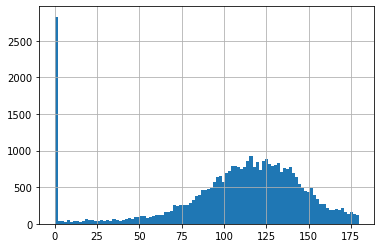

In [70]:
validation_df["angle"].hist(bins=100)

<AxesSubplot:>

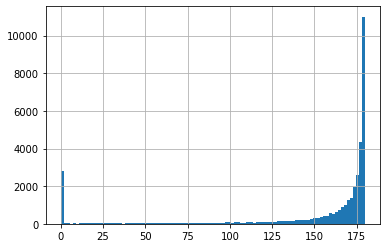

In [72]:
validation_df["max_angle"].hist(bins=100)